In [1]:
from bs4 import BeautifulSoup
import random
# Requests
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [316]:
df_categoria = pd.read_csv('../datos/categorias.csv')
df_mergeo_1 = pd.read_csv('../datos/precios_mergeo.csv')
df_supermercado = pd.read_csv('../datos/supermercados.csv')

Conexión a DDBB

In [317]:
try:
    conexion = psycopg2.connect(
    database = 'Supermercados',
    user = 'postgres',
    password = 'admin',
    host = 'localhost',
    port = '5432')
except OperationalError as e: #el alias es e
    if e.pgcode == errorcodes.INVALID_PASSWORD:
        print('la contraseña es erronea')
    elif e.pgcode == errorcodes.CONNECTION_EXCEPTION:
        print('error de conexion')
    else:
        print(f'el error es el siguiente {e}')

Creación de la tabla de supermercados.

In [318]:
cursor = conexion.cursor() #para crear mi primera tabla, independiente
query_creacion_supermercados = """ 
    CREATE TABLE IF NOT EXISTS Supermercado (
    Id_Supermercado int PRIMARY KEY,
    Supermercado varchar(100));

"""

cursor.execute(query_creacion_supermercados)
conexion.commit()

In [319]:
lista_tuplas2 = [] #creo mi lista de tuplas
for fila in df_supermercado.values:
    lista_tuplas2.append(tuple(fila))

In [320]:
lista_tuplas2

[(1, 'mercadona'),
 (2, 'carrefour'),
 (3, 'eroski'),
 (4, 'dia'),
 (5, 'hipercor'),
 (6, 'alcampo')]

In [321]:
query_creacion_supermercados = 'INSERT INTO Supermercado (Id_Supermercado, Supermercado) VALUES (%s, %s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas2:
    cursor.execute(query_creacion_supermercados, valores)
conexion.commit() # inserto valores a mi tabla

Creación de la tabla Categorías

In [322]:
cursor = conexion.cursor() # creo mi segunda tabla
query_creacion_categorias = """ 
    CREATE TABLE IF NOT EXISTS Categoria (
    Id_Categoria int PRIMARY KEY,
    Categoria varchar(100));

"""
cursor.execute(query_creacion_categorias)
conexion.commit()


In [323]:
lista_tuplas3 = []
for fila in df_categoria.values:
    lista_tuplas3.append(tuple(fila))

In [324]:
lista_tuplas3

[(1, 'aceite-de-girasol'), (2, 'aceite-de-oliva'), (3, 'leche')]

In [325]:
query_creacion_categorias = 'INSERT INTO Categoria (Id_Categoria, Categoria) VALUES (%s, %s)' 
for valores in lista_tuplas3:
    cursor.execute(query_creacion_categorias, valores)
conexion.commit()

In [326]:
cursor = conexion.cursor() #creo mi tabla principal, en último orden porque esta tiene dos fk
query_creacion_tabla_historica = """ 
    CREATE TABLE IF NOT EXISTS datos_historicos (
    Fecha DATE,
    Precio FLOAT NOT NULL,
    Variación FLOAT,
    Artículo VARCHAR(300),
    Id_Categoria INT,
    Id_Supermercado INT,
    CONSTRAINT fk_Categoría FOREIGN KEY (Id_Categoria)
        REFERENCES Categoria(Id_Categoria),
    CONSTRAINT fk_Supermercado FOREIGN KEY (Id_Supermercado)
        REFERENCES Supermercado(Id_Supermercado)
);
"""

cursor.execute(query_creacion_tabla_historica)
conexion.commit()


In [327]:
lista_tuplas1 = []
for fila in df_mergeo_1.values:
    lista_tuplas1.append(tuple(fila))

In [328]:
query_creacion_tabla_historica = 'INSERT INTO datos_historicos (Fecha, Precio, Variación, Artículo, Id_Categoria, Id_Supermercado) VALUES (%s, %s, %s, %s, %s,%s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas1:
    cursor.execute(query_creacion_tabla_historica, valores)
conexion.commit()

Queries

Comparar precios entre supermercados: determinar qué supermercados ofrecen los precios más bajos y cuáles son más caros para cada producto.

In [329]:
cursor=conexion.cursor()
query_min_max_cat="""
SELECT min(precio) AS precio_minimo, max(precio) AS precio_maximo, s.supermercado , c.categoria 
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
WHERE dh.fecha = '26-10-2024'
GROUP BY c.categoria, s.supermercado 
ORDER BY c.categoria, s.supermercado;
"""
cursor.execute(query_min_max_cat)
df_min_max_= pd.DataFrame(cursor.fetchall())

In [330]:
df_min_max_.head()

,0,1,2,3
0,1.45,15.88,alcampo,aceite-de-girasol
1,1.48,37.04,carrefour,aceite-de-girasol
2,1.53,9.98,dia,aceite-de-girasol
3,1.48,11.99,eroski,aceite-de-girasol
4,1.41,8.15,hipercor,aceite-de-girasol


In [331]:
# Renombrar las columnas de acuerdo a su contenido
df_min_max_.columns = ['precio_minimo', 'precio_maximo', 'supermercado', 'categoria']

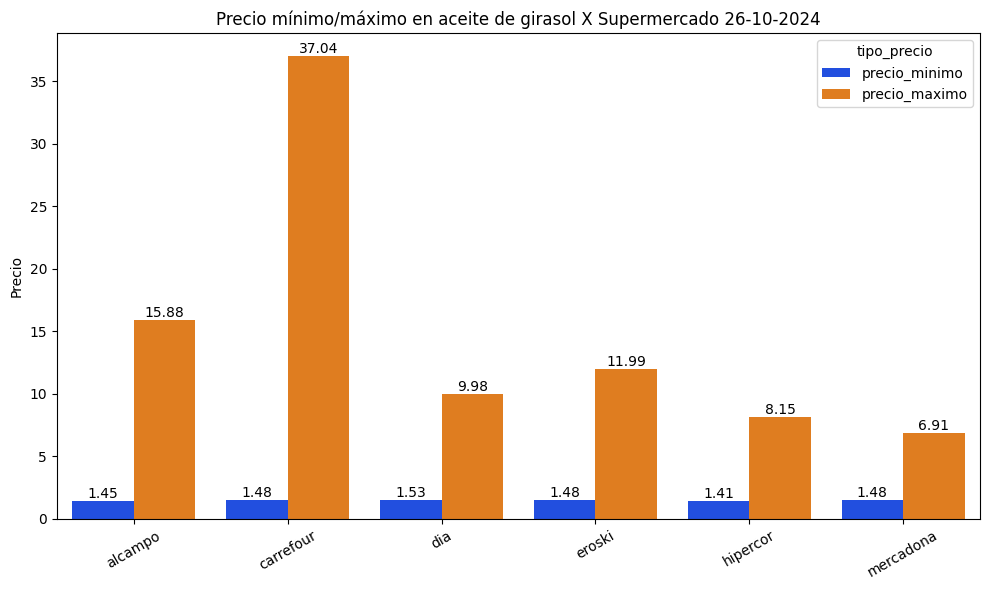

In [392]:
df_long = pd.melt(df_min_max_, id_vars=['categoria', 'supermercado'], #convierto mi df en un formato largo
                  value_vars=['precio_minimo', 'precio_maximo'], #esta columna es la que quiero en formato largo
                  var_name='tipo_precio', value_name='precio') #nueva columna para ambos precios, otra columna para los valores de esta nueva

df_aceite = df_long[df_long['categoria'] == 'aceite-de-girasol']

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_aceite, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="bright"
)

# Personalizar etiquetas y título
plt.title("Precio mínimo/máximo en aceite de girasol X Supermercado 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio")
plt.xticks(rotation=30)  # Asegura que los nombres de supermercados se vean claramente
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge")
plt.show()


In [409]:
df_long.head()

,categoria,supermercado,tipo_precio,precio
0,aceite-de-girasol,alcampo,precio_minimo,1.45
1,aceite-de-girasol,carrefour,precio_minimo,1.48
2,aceite-de-girasol,dia,precio_minimo,1.53
3,aceite-de-girasol,eroski,precio_minimo,1.48
4,aceite-de-girasol,hipercor,precio_minimo,1.41


Tomando en consideración que fueron recopilados los datos de todos los mercados (6), hasta la fecha 26-10-2024, hice la llamada para ver los precios mínimos y máximos para cada categoría en esta fecha.
*** Precio mínimo y máximo en aceite de girasol.
* En cuanto a precio mínimo, el rango de precio tiene mucha similitud entre todos por lo que no existe gran variabilidad. Sin embargo, cabe señalar el precio mínimo del aceite de girasol en Hipercor (1.41).
* En cuanto a precio máximo, el rango de precio si tiene algunas diferencias significativas señalando Carrefour como el mercado con el precio mayor. Es preciso decir que a la hora de tomar los datos no se tomó en cuenta la diferenciación entre tipos de artículos dentro de cada categoría por lo que aquí entra las distintas presentaciones de cada artículo. Este precio mayor puede ser el resultado de un producto de una cantidad mayor que en otros mercads, un farjo o grupo de 6 en 1litro.

Debajo se presenta una tabla donde nos muestra tanto los mínimos como los máximos de esta categoría 'aceite de girasol' para cada mercado.

In [333]:
df_aceite.T

,0,1,2,3,4,5,18,19,20,21,22,23
categoria,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol
supermercado,alcampo,carrefour,dia,eroski,hipercor,mercadona,alcampo,carrefour,dia,eroski,hipercor,mercadona
tipo_precio,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo
precio,1.45,1.48,1.53,1.48,1.41,1.48,15.88,37.04,9.98,11.99,8.15,6.91


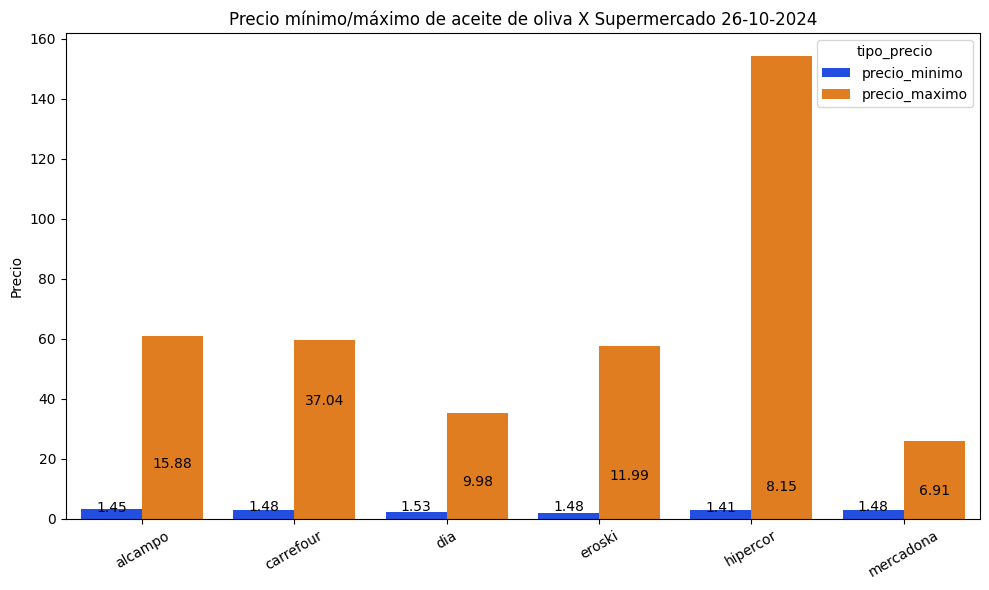

In [390]:
df_aceite_oliva = df_long[df_long['categoria'] == 'aceite-de-oliva']

# Crear el gráfico de barras agrupado
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(
    data=df_aceite_oliva, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="bright"
)

plt.title("Precio mínimo/máximo de aceite de oliva X Supermercado 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio")
plt.xticks(rotation=30)  
plt.tight_layout()
for container in ax.containers:
    ax1.bar_label(container, fmt="%.2f", label_type="edge")
plt.show()

Tomando en consideración que fueron recopilados los datos de todos los mercados (6), hasta la fecha 26-10-2024, hice la llamada para ver los precios mínimos y máximos para cada categoría en esta fecha.
* En cuanto a precio mínimo de aceite de oliva, el rango de precio tiene algo mas de disparidad entre todos. Podemos destacar que el precio mínimo del aceite de girasol en Eroski es 1.89.
* En cuanto a precio máximo, el rango de precio si tiene algunas diferencias significativas señalando Hipercor como el mercado con el precio mayor. Es preciso decir que a la hora de tomar los datos no se tomó en cuenta la diferenciación entre tipos de artículos dentro de cada categoría por lo que aquí entra las distintas presentaciones de cada artículo. Este precio mayor puede ser el resultado de un producto de una cantidad mayor que en otros mercados, un farjo o grupo de 6 en 1litro, incluso hasta 15 litros.

Debajo se presenta una tabla donde nos muestra tanto los mínimos como los máximos de esta categoría 'aceite de oliva' para cada mercado.

In [335]:
df_aceite_oliva.T

,6,7,8,9,10,11,24,25,26,27,28,29
categoria,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva
supermercado,alcampo,carrefour,dia,eroski,hipercor,mercadona,alcampo,carrefour,dia,eroski,hipercor,mercadona
tipo_precio,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo
precio,3.35,2.9,2.15,1.89,2.9,2.9,60.94,59.57,35.14,57.79,154.32,25.95


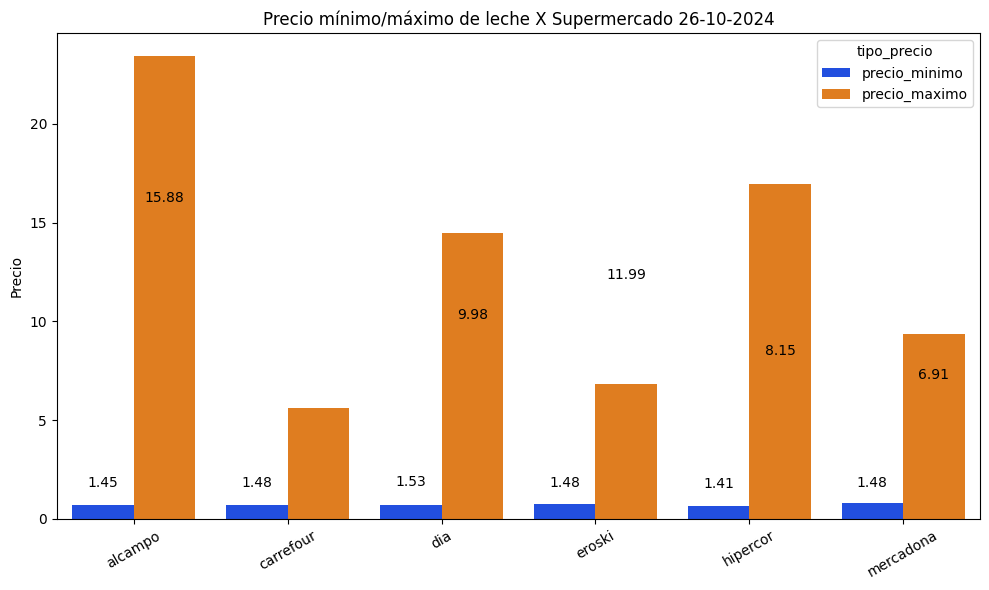

In [391]:
df_leche = df_long[df_long['categoria'] == 'leche']

plt.figure(figsize=(10, 6))
ax2 = sns.barplot(
    data=df_leche, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="bright"
)

plt.title("Precio mínimo/máximo de leche X Supermercado 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio")
plt.xticks(rotation=30)  
plt.tight_layout()
for container in ax.containers:
    ax2.bar_label(container, fmt="%.2f", label_type="edge")
plt.show()

Tomando en consideración que fueron recopilados los datos de todos los mercados (6), hasta la fecha 26-10-2024, hice la llamada para ver los precios mínimos y máximos para cada categoría en esta fecha.
* En cuanto a precio mínimo de la leche, el rango de precio tiene algo mas de disparidad entre todos. Podemos destacar que el precio mínimo de la leche en Hipercor es 0.67.
* En cuanto a precio máximo, el rango de precio encuentro diferencias señalando Alcampo como el mercado con el precio mayor. Es preciso decir que a la hora de tomar los datos no se tomó en cuenta la diferenciación entre tipos de artículos dentro de cada categoría por lo que aquí entra las distintas presentaciones de cada artículo. 

Debajo se presenta una tabla donde nos muestra tanto los mínimos como los máximos de esta categoría 'leche' para cada mercado.

In [337]:
df_leche.T

,12,13,14,15,16,17,30,31,32,33,34,35
categoria,leche,leche,leche,leche,leche,leche,leche,leche,leche,leche,leche,leche
supermercado,alcampo,carrefour,dia,eroski,hipercor,mercadona,alcampo,carrefour,dia,eroski,hipercor,mercadona
tipo_precio,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo
precio,0.68,0.72,0.7,0.74,0.67,0.79,23.43,5.6,14.46,6.85,16.95,9.36


Evolucion de los precios a lo largo del tiempo (Aceite girasol)

In [340]:
paleta_supermercados = {
    'alcampo': '#2ca02c',   # Azul 2ca02c
    'carrefour': '#1f77b4', # Naranja 1f77b4
    'dia': '#d62728',       # Verde d62728
    'eroski': '#8c564b',    # Rojo ff7f0e 8c564b
    'hipercor': '#9467bd',  # Púrpura
    'mercadona': '#ff7f0e'  # Marrón
}

In [341]:
cursor=conexion.cursor()
query_evolucion_precios_aceite_girasol="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS var_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_aceite_girasol)
df_variacion_acumulada_precio_g = pd.DataFrame(cursor.fetchall())

In [342]:
df_variacion_acumulada_precio_g[0] = pd.to_datetime(df_variacion_acumulada_precio_g[0])

In [343]:
df_variacion_acumulada_precio_g.describe()

,0,3
count,6145,6145.000000
mean,2024-08-30 20:17:08.738811904,1.597850
min,2024-06-22 00:00:00,-3.720000
25%,2024-08-04 00:00:00,-0.680000
50%,2024-08-30 00:00:00,1.300000
75%,2024-09-26 00:00:00,3.980000
max,2024-10-26 00:00:00,8.060000
std,NaN,2.750483


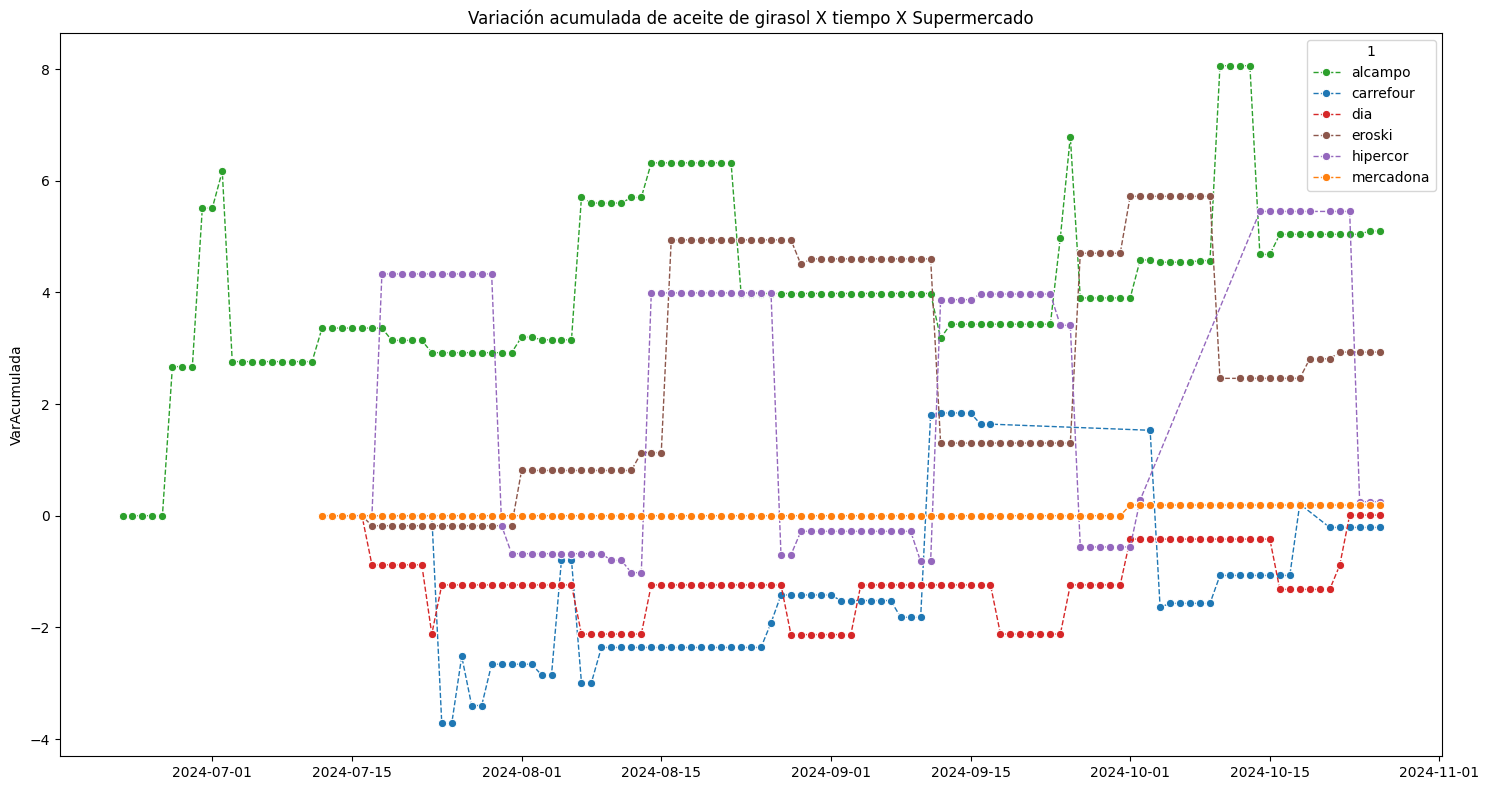

In [344]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_g[0],
              y = df_variacion_acumulada_precio_g[3], 
              hue = df_variacion_acumulada_precio_g[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Variación acumulada de aceite de girasol X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("VarAcumulada")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En esta visualización muestra la variación del aceite de girasol, de los precios de los artículos, de manera acumulada. Esto quiere decir que cada variación que existe en una categoría se irá acumulando e irá subiendo y bajando en consecuencia. Todas empiezan en 0 pero luego se observa como esta variación va en aumento o en depreciación dependiendo del alza o baja de sus precios, para entonces quedar en un nuevo escalón. De esta manera se puede ver cómo estos cambios se mantienen en el tiempo y como se perciben cuando existe tiempo de alzas y bajas continuas.

A simple vista se observa como hubo una variación para todos los supermercados entre mediados de julio--agosto en los cambios al aceite de girasol. Sin embargo, entre mediados de septiembre y octubre se aprecia un mantenimiento casi general seguido de una liera fluctuación.

El mercado que presenta menor cambio y a la vez mayor regularidad es el Mercadona. Dia se mantuvo con un comportamiento bastante irregular oscilando entre subidas y bajas de sus precios.

Evolucion de los precios a lo largo del tiempo (Aceite de oliva)

In [345]:
cursor=conexion.cursor()
query_evolucion_precios_aceite_oliva="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_aceite_oliva)
df_variacion_acumulada_precio_adeo = pd.DataFrame(cursor.fetchall())

In [346]:
df_variacion_acumulada_precio_adeo[0] = pd.to_datetime(df_variacion_acumulada_precio_adeo[0])


In [347]:
df_variacion_acumulada_precio_adeo.describe()

,0,3
count,58301,58301.000000
mean,2024-08-26 16:07:58.180477440,-78.226876
min,2024-06-22 00:00:00,-206.770000
25%,2024-07-30 00:00:00,-112.500000
50%,2024-08-25 00:00:00,-79.380000
75%,2024-09-22 00:00:00,-40.940000
max,2024-10-26 00:00:00,19.400000
std,NaN,44.339702


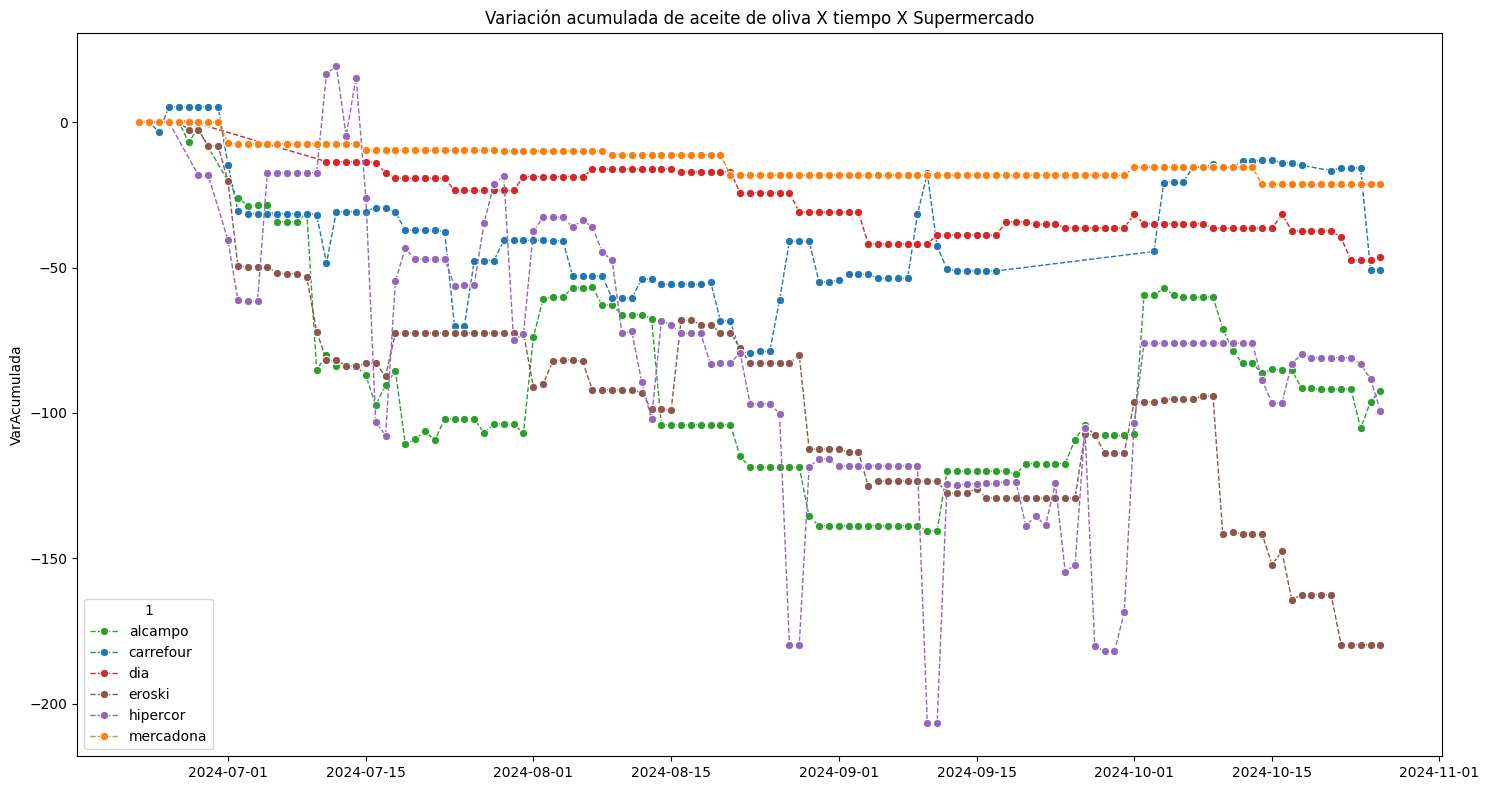

In [395]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_adeo[0],
              y = df_variacion_acumulada_precio_adeo[3], 
              hue = df_variacion_acumulada_precio_adeo[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Variación acumulada de aceite de oliva X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("VarAcumulada")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En esta visualización se puede observar la evolución de precios a través de la variación acumulada para el aceite de oliva en el tiempo registrado. A simple vista, se ve un descenso general en los precios vía su variación. Quiero decir que contantemente este fue bajando aunque tuvo momentos en los que realizó subidas (sobre todo en el mes de agosto). Sin embargo, estas no fueron tan grandes como para regresar a su precio anterior. Lo que quiere decir que desde el registro el descenso ha sido uniforme. Señalo a Mercadona y Día como aquello con menor variación, e Hipercor con una mayor variación acumulada en su descenso. Alcampo se mantiene en un ida y vuelta en su picada.
* Se puede observar ciertas alzas generalizadas a partir del inicio del mes de octubre.

In [349]:
cursor=conexion.cursor()
query_evolucion_precios_leche="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_leche)
df_variacion_acumulada_precio_leche = pd.DataFrame(cursor.fetchall())

In [350]:
df_variacion_acumulada_precio_leche[0] = pd.to_datetime(df_variacion_acumulada_precio_leche[0])

In [351]:
df_variacion_acumulada_precio_leche.head()

,0,1,2,3
0,2024-07-15,alcampo,leche,0.0
1,2024-07-15,alcampo,leche,0.0
2,2024-07-15,alcampo,leche,0.0
3,2024-07-15,alcampo,leche,0.0
4,2024-07-15,alcampo,leche,0.0


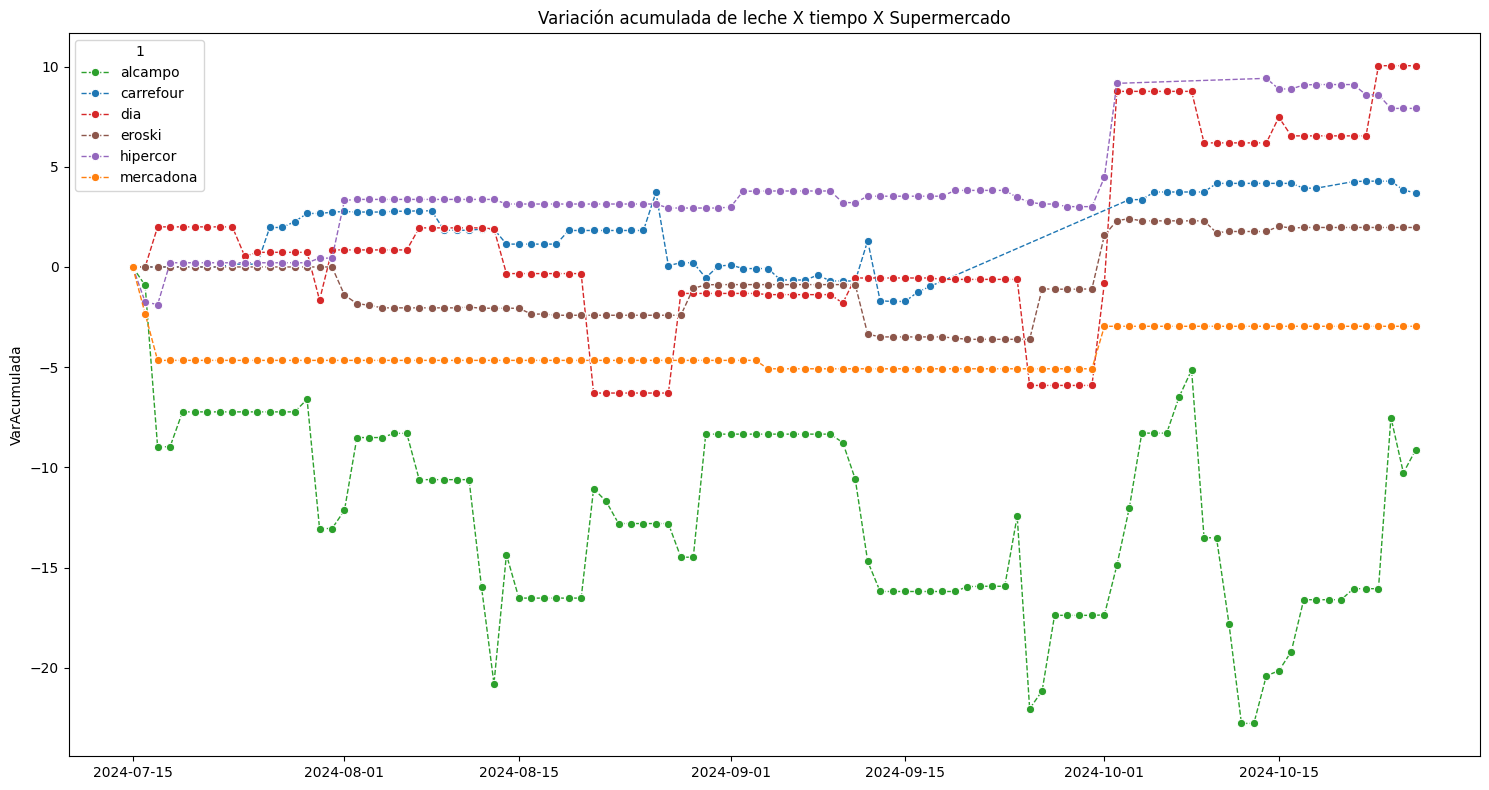

In [396]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_leche[0],
              y = df_variacion_acumulada_precio_leche[3], 
              hue = df_variacion_acumulada_precio_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Variación acumulada de leche X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("VarAcumulada")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

Para ver la variación acumulada de la leche en el tiempo se puede observar que casi todos tuviero un imicio continuo del mismo precio, a diferencia de alcampo. Estos dos siguen un patrón distinto a los demás mercados ya que presentan una variación acumulada en negativo: mercadona se mantuvo muy similar al precio original mientras que alcampo tuvo muchas bajas aunque por momentos se acercó a su precio original. Los demás tuvieron un comportamiento más regular. Estuvieron oscilando cerca del precio original, aunque luego presentaron una ligera variación donde se mantuvieron.

Anomalías de precios por tiempo (aceite de girasol)

In [353]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_girasol="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_girasol)
df_anomalias_girasol= pd.DataFrame(cursor.fetchall())

In [354]:
df_anomalias_girasol[0] = pd.to_datetime(df_anomalias_girasol[0])

In [355]:
df_anomalias_girasol.head()

,0,1,2,3
0,2024-06-22,alcampo,aceite-de-girasol,0.0
1,2024-06-23,alcampo,aceite-de-girasol,0.0
2,2024-06-24,alcampo,aceite-de-girasol,0.0
3,2024-06-25,alcampo,aceite-de-girasol,0.0
4,2024-06-26,alcampo,aceite-de-girasol,0.0


In [356]:
df_anomalias_girasol.describe()

,0,3
count,631,631.000000
mean,2024-08-30 15:44:47.163233024,0.013106
min,2024-06-22 00:00:00,-5.200000
25%,2024-08-04 00:00:00,0.000000
50%,2024-08-30 00:00:00,0.000000
75%,2024-09-27 00:00:00,0.000000
max,2024-10-26 00:00:00,5.170000
std,NaN,0.767295


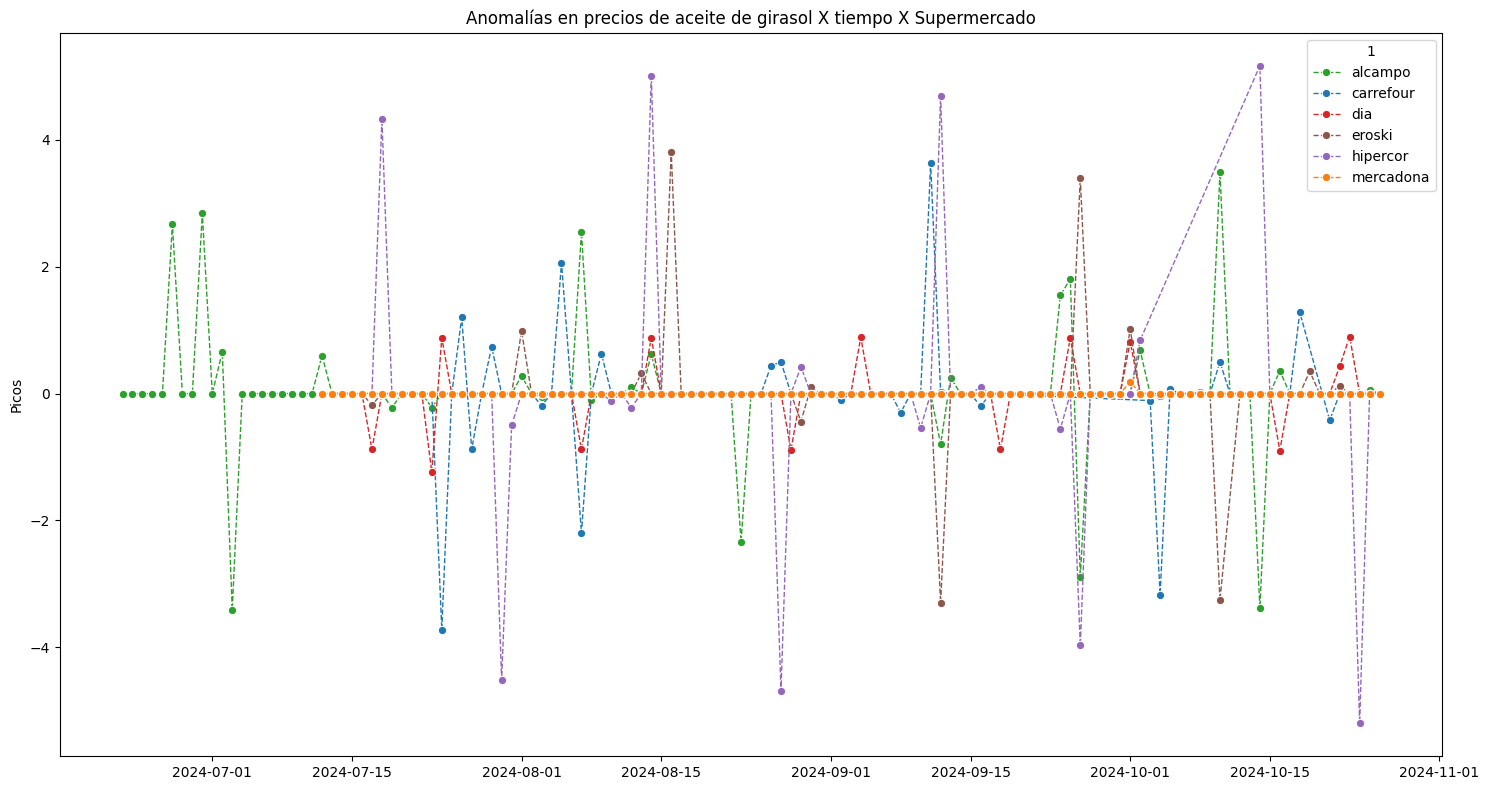

In [357]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_girasol[0],
              y = df_anomalias_girasol[3], 
              hue = df_anomalias_girasol[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Anomalías en precios de aceite de girasol X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Picos")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En el gráfico se pueden observar anomalías de precios para el aceite de girasol (aumentos y bajadas en los distintos supermercados) desde el inicio del registro histórico. No se observa ninguna gran variación de anomalías en mercadona, mientras que el Día mantiene un funcionamiento regular entre subidas y bajadas ligeras. 
En el caso de Carrefour e Hipercor, se ven variaciones mas notables tanto en aumento como descenso destacando movimientos entre mediados de julio a mediados de agosto. Eroski también mantiene un comportamiento regular con algunas ligeras subidas, mientras que Alcampo presenta un inicio con picadas y un periodo mas reciente con ambos movimientos. En el mes presente, se observan subidas y bajas intermitentes.

Anomalías por aceite de oliva

In [358]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_aceiteoliva="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_aceiteoliva)
df_anomalias_oliva= pd.DataFrame(cursor.fetchall())

In [359]:
df_anomalias_oliva[0] = pd.to_datetime(df_anomalias_oliva[0])

In [360]:
df_anomalias_oliva.head()

,0,1,2,3
0,2024-06-22,alcampo,aceite-de-oliva,0.0
1,2024-06-23,alcampo,aceite-de-oliva,0.0
2,2024-06-24,alcampo,aceite-de-oliva,0.0
3,2024-06-25,alcampo,aceite-de-oliva,0.0
4,2024-06-26,alcampo,aceite-de-oliva,0.0


In [361]:
df_anomalias_oliva.describe()

,0,3
count,720,720.000000
mean,2024-08-25 02:04:00.000000256,-0.680792
min,2024-06-22 00:00:00,-88.580000
25%,2024-07-26 00:00:00,0.000000
50%,2024-08-25 00:00:00,0.000000
75%,2024-09-25 00:00:00,0.000000
max,2024-10-26 00:00:00,82.350000
std,NaN,11.247102


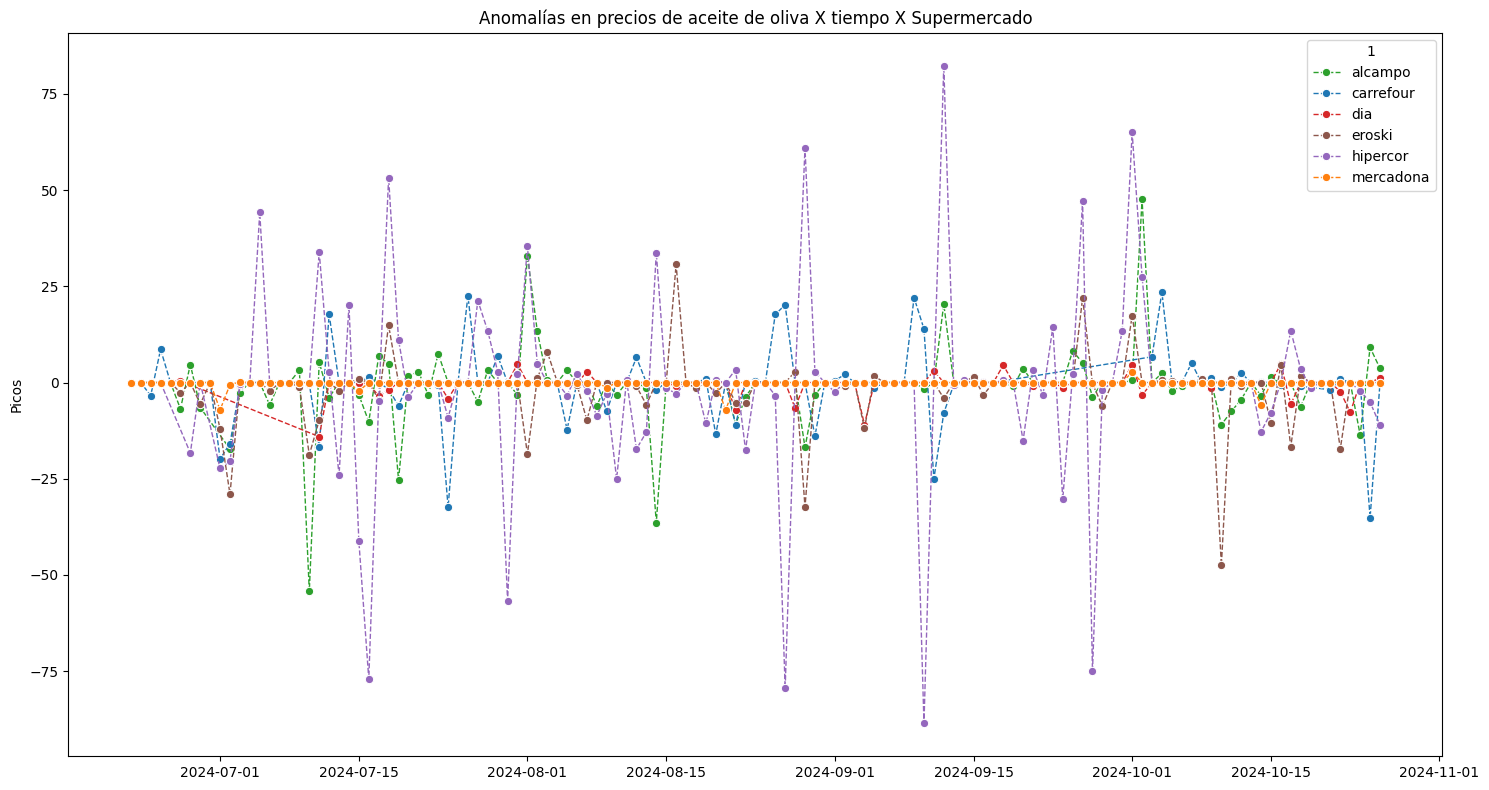

In [362]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_oliva[0],
              y = df_anomalias_oliva[3], 
              hue = df_anomalias_oliva[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Anomalías en precios de aceite de oliva X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Picos")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En referencia al aceite de oliva, se puede ver una gráfica con mucho movimiento. A principio hubo un descenso en variación general, seguido con un periodo estable para luego dar entrada a una serie de movimientos en alza y baja hasta mediados de agosto. Desde mediados de agosto se produjo picos en descenso general para luego volver a un momento prácticamente general de estabilidad. Luego a principios d octubre hubo varios picos en la variación casi en todos los mercados pero esto sería contrarrestado por los picos en descenso que le seguirían para casi todos.
* Es preciso señalar el caso de hipercor como aquel que sufrió los picos más altos y más bajos en todo el tiempo medido.

Anomalías por leche

In [363]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_leche="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_leche)
df_anomalias_leche= pd.DataFrame(cursor.fetchall())

In [364]:
df_anomalias_leche[0] = pd.to_datetime(df_anomalias_leche[0])

In [365]:
df_anomalias_leche.head()

,0,1,2,3
0,2024-07-15,alcampo,leche,0.00
1,2024-07-16,alcampo,leche,-0.92
2,2024-07-17,alcampo,leche,-8.05
3,2024-07-18,alcampo,leche,0.00
4,2024-07-19,alcampo,leche,1.74


In [366]:
df_anomalias_leche.describe()

,0,3
count,596,596.000000
mean,2024-09-03 05:09:15.704698112,0.019362
min,2024-07-15 00:00:00,-9.610000
25%,2024-08-08 00:00:00,0.000000
50%,2024-09-02 00:00:00,0.000000
75%,2024-09-29 00:00:00,0.000000
max,2024-10-26 00:00:00,9.560000
std,NaN,1.345268


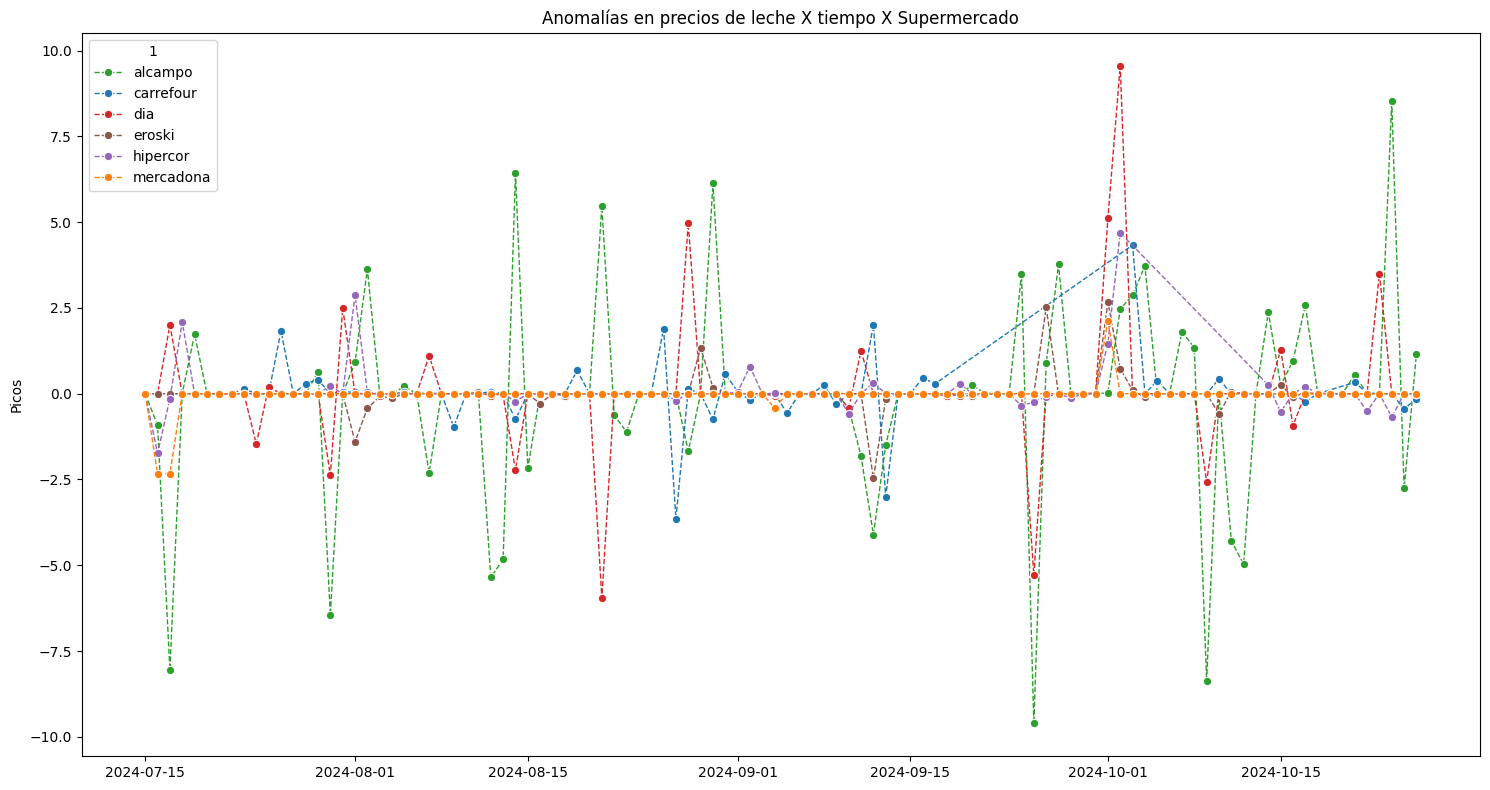

In [367]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_leche[0],
              y = df_anomalias_leche[3], 
              hue = df_anomalias_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Anomalías en precios de leche X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Picos")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

Con respecto a la leche, hubo pequeños aumentos en su variación hacia principios de agosto en cadenas como dia, alcampo e hipercor, mientras que las demás mantenían su precio o incluso tenían ligeros descensos. Para principios de septiembre se puede observar un aumento en algunos seguido de un descenso general para mediados del mismo mes en general. Para octubre, se inicia con picos de variación seguido de días sin movimiento para volver a presentarse picos. 
* Carrefour se mantiene muy constante en cuanto a su variación, a diferencia de mercados como Día y Alcampo.
* Los demás, mantienen un movimiento casi nulo.

Cambios de precio Aceite de girasol

In [368]:
#variacion buena por picadas

cursor=conexion.cursor()
query_cambios_precio_girasol="""
SELECT fecha, s.supermercado , c.categoria , avg(dh.precio) AS cambio_promedio_ag
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_girasol)
df_cambios_girasol= pd.DataFrame(cursor.fetchall())

In [369]:
df_cambios_girasol[0] = pd.to_datetime(df_cambios_girasol[0])

In [370]:
df_cambios_girasol.describe()

,0,3
count,631,631.000000
mean,2024-08-30 15:44:47.163233024,4.666215
min,2024-06-22 00:00:00,1.270000
25%,2024-08-04 00:00:00,3.718333
50%,2024-08-30 00:00:00,4.100000
75%,2024-09-27 00:00:00,4.986667
max,2024-10-26 00:00:00,10.271667
std,NaN,1.575741


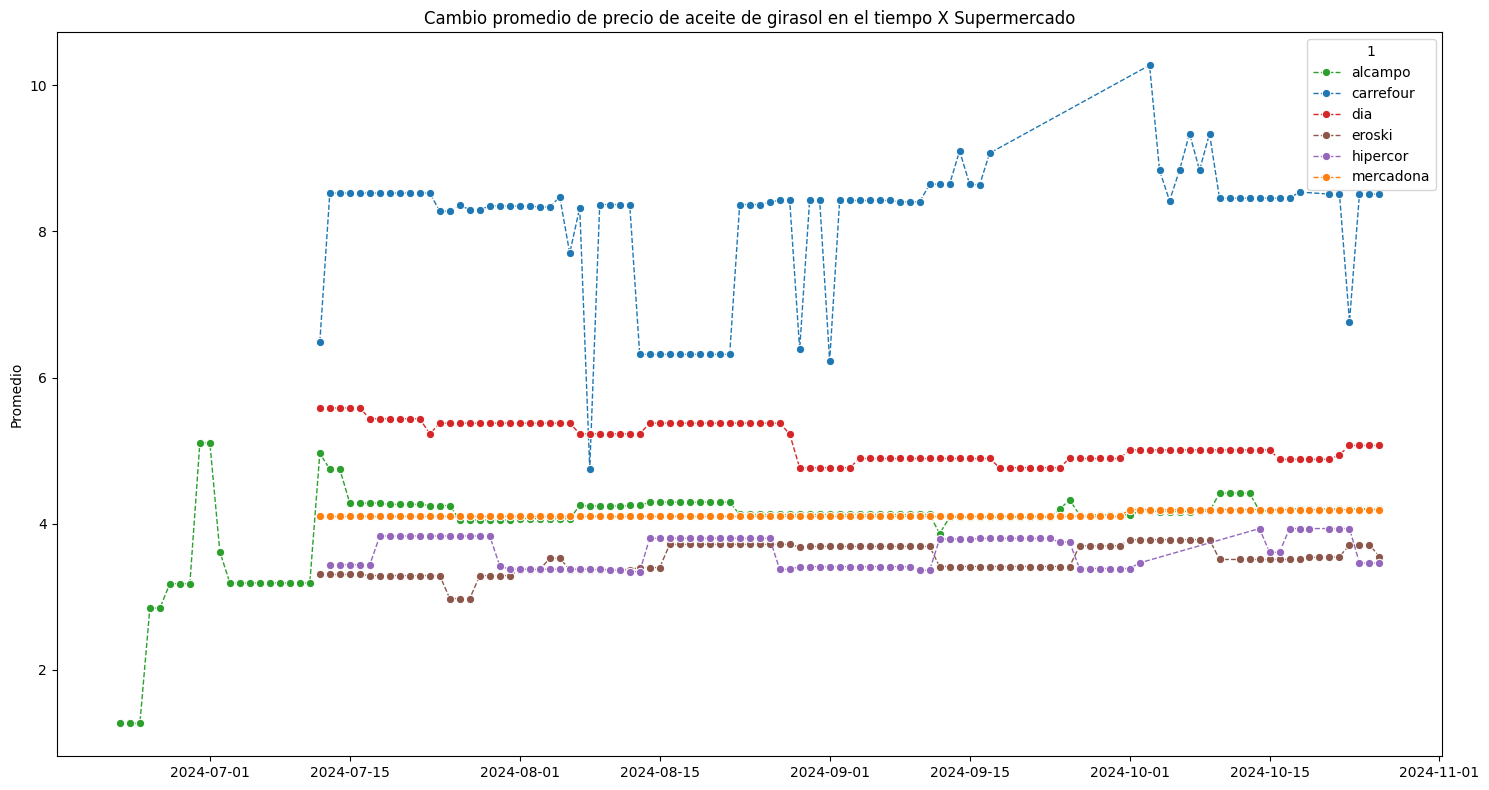

In [371]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_girasol[0],
              y = df_cambios_girasol[3], 
              hue = df_cambios_girasol[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Cambio promedio de precio de aceite de girasol en el tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Promedio")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

De esta forma se puede comprobar el aumento, o baja, promedio que se hace por categoría. 
* En casi todos los supermercados, a partir de julio la media del aceite de girasol se mantuvo en precios relativamente semejantes casi en todos los casos. Aunque se distinguen dos casos: Dia y Carrefour. Estos dos tienen un promedio de precio por encima de los demás mercados.
El caso con la media más alta es de Carrefour, mientras que la media más baja se debate entre hipercor y eroski.

In [372]:
cursor=conexion.cursor()
query_cambios_precio_oliva="""
SELECT fecha, s.supermercado , c.categoria , avg(dh.precio) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_oliva)
df_cambios_oliva= pd.DataFrame(cursor.fetchall())

In [373]:
df_cambios_oliva[0] = pd.to_datetime(df_cambios_oliva[0])

In [374]:
df_cambios_oliva.describe()

,0,3
count,720,720.000000
mean,2024-08-25 02:04:00.000000256,16.425977
min,2024-06-22 00:00:00,7.450000
25%,2024-07-26 00:00:00,12.596174
50%,2024-08-25 00:00:00,14.190428
75%,2024-09-25 00:00:00,20.073852
max,2024-10-26 00:00:00,29.042857
std,NaN,4.337599


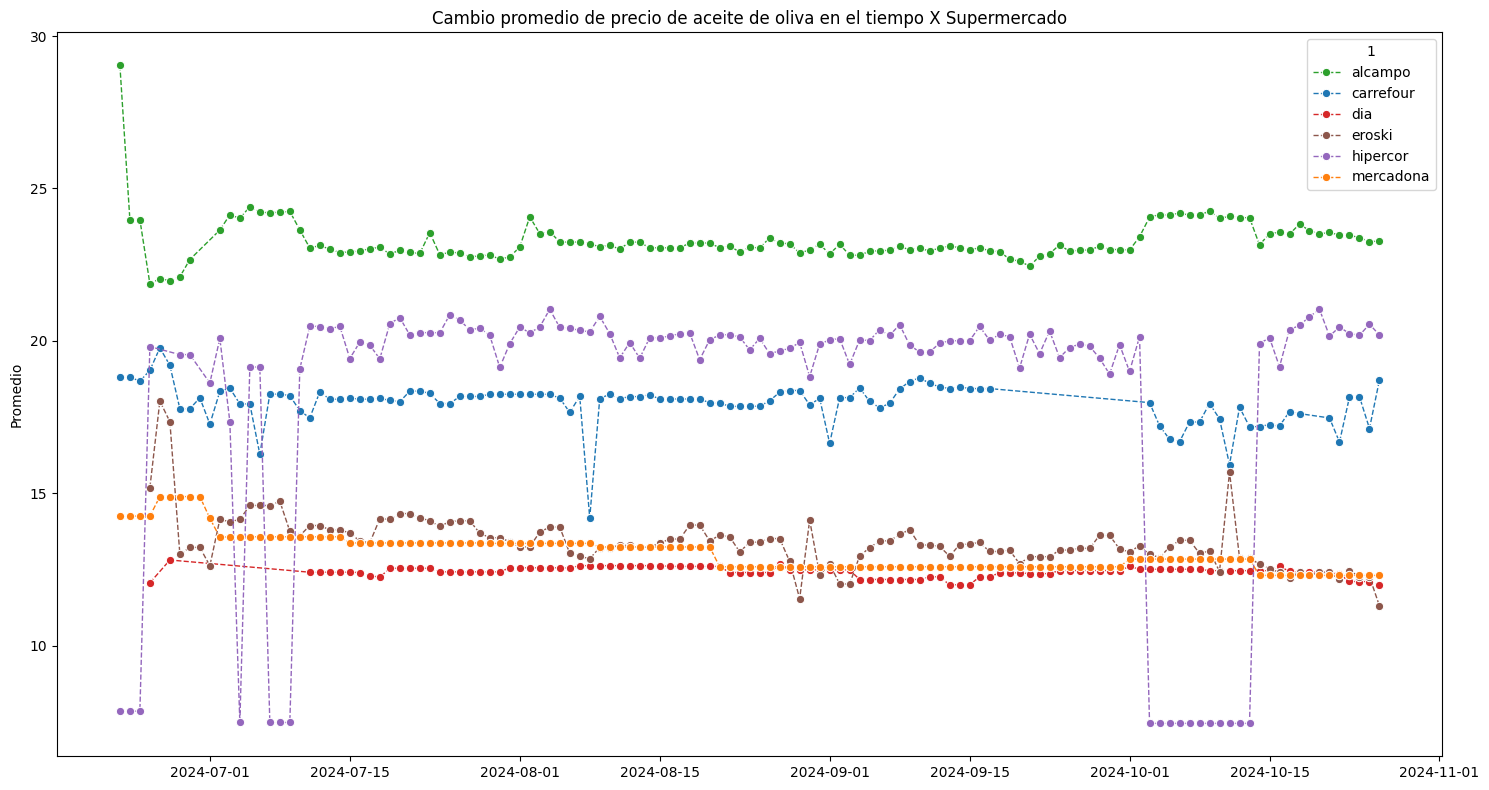

In [375]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_oliva[0],
              y = df_cambios_oliva[3], 
              hue = df_cambios_oliva[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Cambio promedio de precio de aceite de oliva en el tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Promedio")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

* A primera vista, se puede apreciar que la media más alta en cuanto al tiempo estudiado es de Alcampo, seguido por Hipercor y Carrefour.
Los demás ssupermercados (mercadona, dia, eroski) se mantienen en un rango similar entre ellas. Aunque por momentos unas destacan por encima de otras.
El caso de Dia es el que presenta el precio más uniforme a lo largo del tiempo. 

In [376]:
cursor=conexion.cursor()
query_cambios_precio_leche="""
SELECT fecha, s.supermercado , c.categoria , avg(dh.precio) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_leche)
df_cambios_leche= pd.DataFrame(cursor.fetchall())

In [377]:
df_cambios_leche[0] = pd.to_datetime(df_cambios_leche[0])

In [378]:
df_cambios_leche.describe()

,0,3
count,596,596.000000
mean,2024-09-03 05:09:15.704698112,2.821844
min,2024-07-15 00:00:00,1.434906
25%,2024-08-08 00:00:00,1.572158
50%,2024-09-02 00:00:00,3.621481
75%,2024-09-29 00:00:00,4.032564
max,2024-10-26 00:00:00,5.248553
std,NaN,1.191561


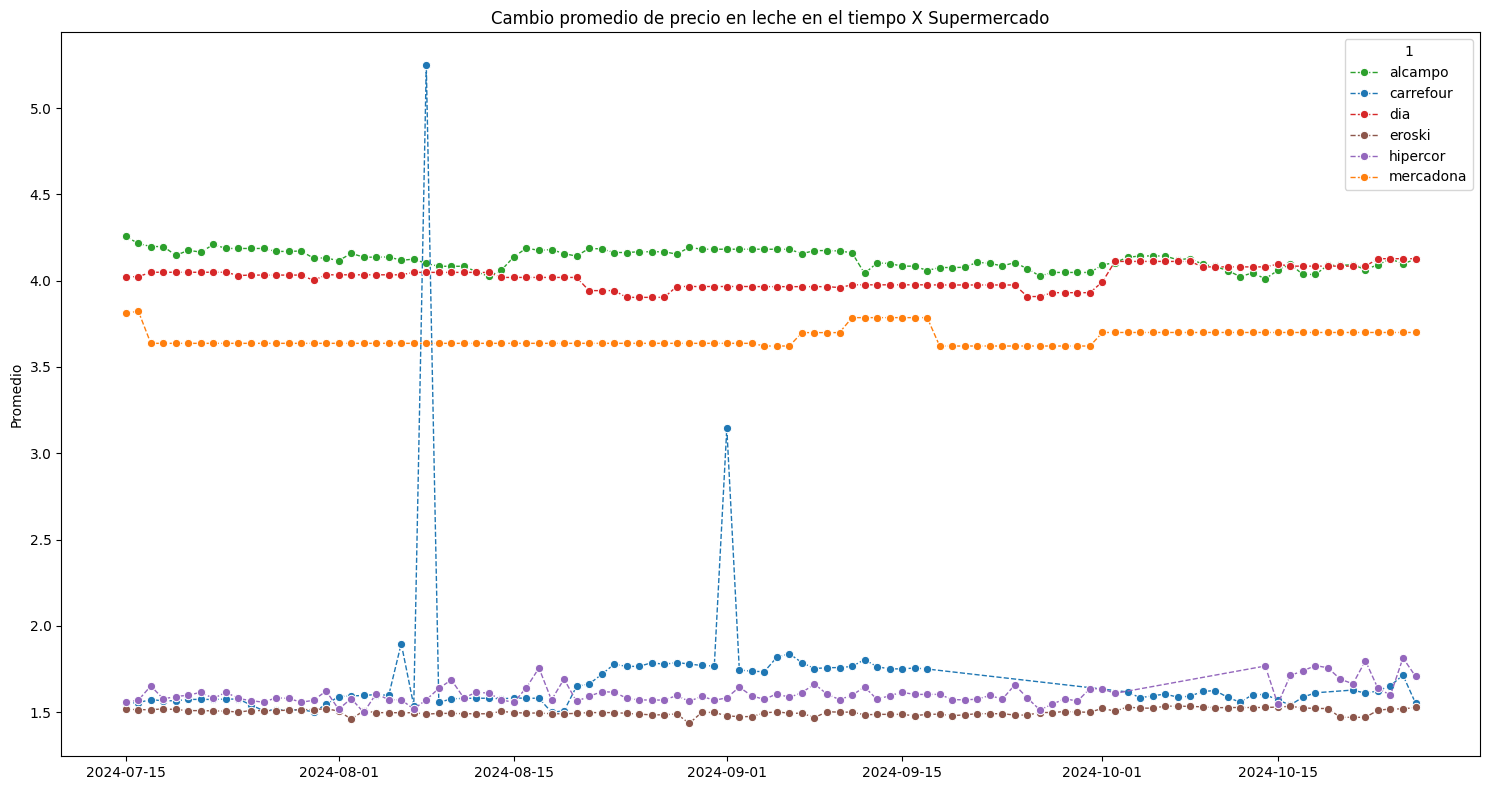

In [379]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_leche[0],
              y = df_cambios_leche[3], 
              hue = df_cambios_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Cambio promedio de precio en leche en el tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Promedio")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

Con respecto a la leche, se pueden apreciar dos distintas distribuciones: en los precios más bajos se encuentran: carrefour, hipercor y eroski. Sin embargo, se aprecian ciertos picos en el promedio de carrefour. 
* Por otro lado, más arriba está la otra disposición donde se ven: alcampo, dia y mercadona. Estas tres llevan un promedio de precio similar. eso puede deberse a la diversidad de productos de esta categoría ya que en relación a la disposición de estos en distintas presentaciones puede elevarse el precio promedio.

Análisis de la Dispersión de Precios: Evaluar la variabilidad de los precios de un mismo producto en diferentes supermercados.

In [380]:
# cursor=conexion.cursor()
# query_dispersion_precios= """
# SELECT c.categoria , s.supermercado, 
# avg(dh.precio) AS precio_promedio,
# min(dh.precio) AS precio_minimo,
# max(dh.precio) AS precio_maximo
# FROM datos_historicos dh 
# inner JOIN supermercado s 
# ON dh.id_supermercado = s.id_supermercado 
# INNER JOIN categoria c 
# ON dh.id_categoria = c.id_categoria 
# GROUP BY c.categoria, s.supermercado 
# ORDER BY c.categoria;
# """
# cursor.execute(query_dispersion_precios)
# df_dispersion_precios= pd.DataFrame(cursor.fetchall())

In [381]:
# df_dispersion_precios.head()

Comparación de Precios Promedio: Calcular y comparar los precios promedio de cada producto en diferentes supermercados.

In [382]:
cursor=conexion.cursor()
query_comparar_precios = """
SELECT round(CAST (avg(precio) AS NUMERIC), 2) AS precio_pomedio, s.supermercado , c.categoria 
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
WHERE dh.fecha = '26-10-2024'
GROUP BY s.supermercado , c.categoria 
ORDER BY c.categoria;
"""
cursor.execute(query_comparar_precios)
df_comparacion_precios = pd.DataFrame(cursor.fetchall())

In [383]:
df_comparacion_precios.head()

,0,1,2
0,4.21,alcampo,aceite-de-girasol
1,8.51,carrefour,aceite-de-girasol
2,5.07,dia,aceite-de-girasol
3,3.55,eroski,aceite-de-girasol
4,3.46,hipercor,aceite-de-girasol


In [405]:
df_prom_ag = df_comparacion_precios[df_comparacion_precios[2] == 'aceite-de-girasol']
df_prom_ado = df_comparacion_precios[df_comparacion_precios[2] == 'aceite-de-oliva']
df_prom_leche = df_comparacion_precios[df_comparacion_precios[2] == 'leche']

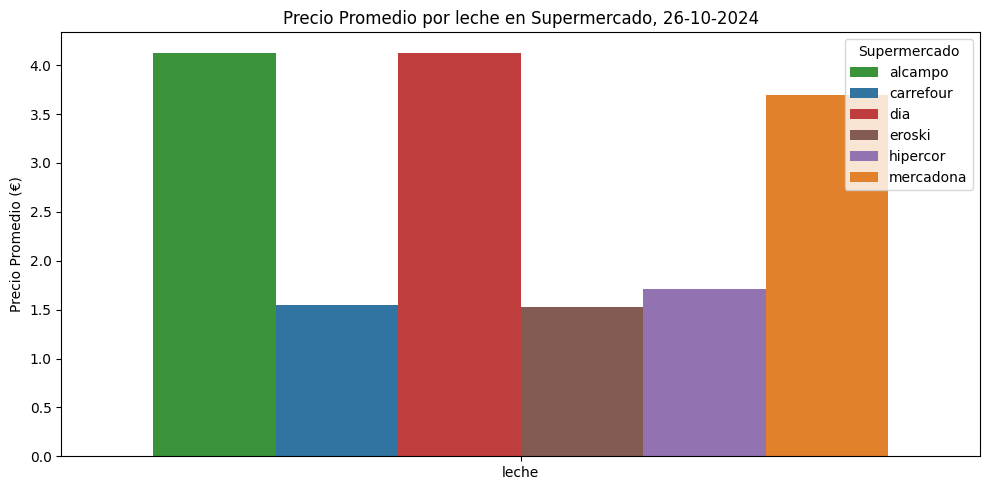

In [407]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_prom_leche, 
    x=2, 
    y=0, 
    hue=1, 
    palette=paleta_supermercados
)

plt.title("Precio Promedio por leche en Supermercado, 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio Promedio (€)")
plt.xticks(rotation=0)
plt.legend(title="Supermercado")
plt.tight_layout()

Promedio

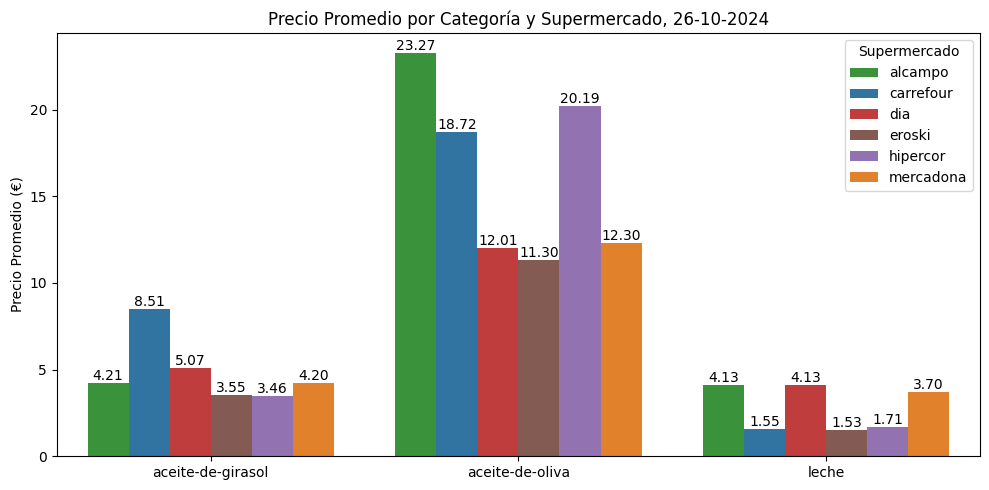

In [397]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_comparacion_precios, 
    x=2, 
    y=0, 
    hue=1, 
    palette=paleta_supermercados
)

plt.title("Precio Promedio por Categoría y Supermercado, 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio Promedio (€)")
plt.xticks(rotation=0)
plt.legend(title="Supermercado")
plt.tight_layout()

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt="%.2f", label_type="edge")

plt.show()


Esta visualización presenta el precio promedio para la fecha que se llevó a cabo la toma de la información, 26-10-2024. Es mucho más fácil de visualzar aquí un promedio más bajo y más bajo. 
* En el aceite de girasol, hay un promedio máximo de 8.51 en carrefour mientras que el mínimo es 3.46 en hipercor.
* En el aceite de oliva, hay un promedio máximo de 23.27 en alcampo mientras que el mínimo lo ofrece eroski con 11.30
* En la leche, hay un promedio máximo de 4.13 compartido en alcampo y dia. Mientras que el promedio mínimo lo presenta eroski.

In [385]:
cursor.close()
conexion.close()

El estudio sobre los precios de estos 3 productos en los 6 supermercados permite observar patrones importantes en la estabilidad, variabilidad y competitividad de precios en el mercado. Aquí dejo los puntos fuertes del análisis realizado:

### Aceite de Girasol:

- Estabilidad en el Tiempo: Desde julio, la mayoría de los supermercados mantuvieron precios similares, con excepción de Carrefour y Dia, que presentaron un promedio superior al de sus competidores. Carrefour destaca particularmente por tener la media más alta de precio, mientras que Hipercor y Eroski ofrecen precios más bajos y estables.
- Precios Mínimos y Máximos: Carrefour tiene el precio promedio más alto (8.51), mientras que el precio más bajo se encuentra en Hipercor (3.46). Esta diferencia refleja una posible estrategia de Carrefour orientada a ofertas de mayor valor agregado (probablemente presentaciones más grandes o de mejor calidad), mientras que Hipercor se mantiene competitivo con opciones de menor costo.
- Anomalías de Precio: Mercadona se distingue por su constancia, mientras que Carrefour e Hipercor han mostrado variaciones destacadas, con incrementos y descensos notables, especialmente entre mediados de julio y agosto. Esto puede indicar una mayor flexibilidad en el ajuste de precios para adaptarse a la demanda o a cambios en los costos.

### Aceite de Oliva:

- Variación Acumulada y Consistencia: Aunque se observan fluctuaciones en el precio, la tendencia ha sido una baja acumulativa en todos los supermercados, con picos de incremento en agosto y nuevamente en octubre, lo cual se alinea con cambios estacionales en la demanda. Hipercor presenta los mayores picos en variación, mientras que Mercadona y Dia muestran una menor volatilidad.
- Precio Promedio en Fecha de Corte: El precio promedio más alto fue en Alcampo (23.27), mientras que Eroski presenta el precio más bajo (11.30). Esta diferencia puede estar relacionada con la diversidad de presentaciones de productos, desde botellas grandes hasta opciones en pack.
- Tendencia de Ajustes en Octubre: Durante octubre se observan incrementos en varios supermercados, posiblemente en respuesta a factores de reposición de inventario o demandas estacionales.

### Leche:

- Distribución de Precios y Consistencia: Carrefour, Hipercor y Eroski lideran en precios más bajos, con un precio promedio que se mantiene más constante en el tiempo, aunque Carrefour mostró picos ocasionales. Por otro lado, Alcampo, Dia y Mercadona presentan precios promedio más elevados, lo cual podría estar vinculado con una mayor oferta de presentaciones y diversificación de productos.
- Precio Promedio en Fecha de Corte: El promedio más alto se encuentra en Alcampo y Dia (4.13), mientras que Eroski destaca por su precio promedio más bajo, lo que lo convierte en una opción económica constante para el consumidor.
- Estabilidad: En términos de variación acumulada, Carrefour es notable por su estabilidad, contrastando con Alcampo y Dia, que muestran un comportamiento de precios más dinámico.

#### Resumen de Puntos Fuertes

- Mercadona y Carrefour como Opciones Constantes: Mercadona es altamente estable en su variación de precios en productos como el aceite de girasol y la leche. Carrefour, aunque presenta algunas variaciones, sigue siendo una opción constante en la mayoría de los productos analizados.
- Dinamismo en Hipercor y Alcampo: Ambos supermercados muestran estrategias de precios variadas, especialmente en el aceite de oliva y girasol, lo cual podría responder a promociones temporales o ajustes en función de la competencia.
- Tendencias de Precio en Octubre: Octubre marca una serie de ajustes de precios en todas las categorías, con picos ascendentes y descendentes, lo que podría corresponder a dinámicas de oferta y demanda típicas de fin de temporada o a reajustes en los precios de reposición.
- Este análisis permite visualizar las ventajas y posicionamientos de cada supermercado. Las estrategias de precios reflejan no solo la estructura de costos y la diversificación de productos, sino también el ajuste de cada supermercado a las demandas del consumidor, siendo un recurso clave para aquellos que buscan economía o estabilidad en sus compras.